In [1]:
import torch
from scipy.sparse.linalg import eigsh
import numpy as np
import yastn
import yastn.tn.fpeps as fpeps
import yastn.operators as op_mod
from tqdm import tqdm
from functions_fpeps import *
from functions_ed import *
import matplotlib.pyplot as plt

NUM_THREADS = 8 
torch.set_num_threads(NUM_THREADS)

In [2]:
L_x, L_y = 2, 2
t = 1.0
U = 10.0
mu = 0.0
dtau = 0.05
n_steps = 20
D_target = 4
chi = 10 * D_target

In [3]:
ops = op_mod.SpinfulFermions(sym="U1xU1", backend='torch', default_dtype='float64')

I = ops.I()
c_up, cdag_up, n_up = ops.c('u'), ops.cp('u'), ops.n('u')
c_dn, cdag_dn, n_dn = ops.c('d'), ops.cp('d'), ops.n('d')

state_up = ops.vec_n((1, 0))
state_dn = ops.vec_n((0, 1))

In [4]:
geometry = fpeps.SquareLattice(dims=(L_x, L_y), boundary="obc")

In [5]:
vectors = {}
for (x, y) in geometry.sites():
    if (x + y) % 2 == 0:
        vectors[(x, y)] = state_up
    else:
        vectors[(x, y)] = state_dn

psi = fpeps.product_peps(geometry=geometry, vectors=vectors)

In [6]:
g_hop_up = fpeps.gates.gate_nn_hopping(t, dtau / 2, I, c_up, cdag_up)
g_hop_dn = fpeps.gates.gate_nn_hopping(t, dtau / 2, I, c_dn, cdag_dn)
g_loc = fpeps.gates.gate_local_Coulomb(mu, mu, U, dtau / 2, I, n_up, n_dn)

gates = fpeps.gates.distribute(
    geometry,
    gates_nn=[g_hop_up, g_hop_dn],
    gates_local=g_loc
)

In [7]:
env_ntu = fpeps.EnvNTU(psi, which="NN")
opts_svd_ntu = {
    "D_total": D_target,
}


energy_arr = np.zeros((n_steps))
for step in tqdm(range(n_steps)):
    infos = fpeps.evolution_step_(env_ntu, gates, opts_svd=opts_svd_ntu)

    psi = env_ntu.psi

    env_ctm = fpeps.EnvCTM(psi, init="eye")
    opts_svd_ctm = {
        "D_total": chi,
        "tol": 1e-10,
    }

    ctm_iter = env_ctm.ctmrg_(
        opts_svd=opts_svd_ctm,
        iterator=True,
        max_sweeps=50,
    )

    energy_old = 0.0
    tol_energy = 1e-7
    sites_list = list(geometry.sites())
    bonds_list = list(geometry.bonds())
    num_sites = len(sites_list)
    num_bonds = len(bonds_list)
    z_eff = 2.0 * num_bonds / num_sites
    
    on_site_op = (n_up - I / 2) @ (n_dn - I / 2)
    ev_loc = env_ctm.measure_1site(on_site_op)
    ev_loc_mean = mean_dict_values(ev_loc)

    ev_cdagc_up = env_ctm.measure_nn(cdag_up, c_up)
    ev_cdagc_dn = env_ctm.measure_nn(cdag_dn, c_dn)
    ev_cdagc_up_mean = mean_dict_values(ev_cdagc_up)
    ev_cdagc_dn_mean = mean_dict_values(ev_cdagc_dn)

    E_kin_site = - z_eff * t * (ev_cdagc_up_mean + ev_cdagc_dn_mean)
    E_loc_site = U * ev_loc_mean

    energy = E_kin_site + E_loc_site
    
    energy_arr[step] = energy

100%|██████████| 20/20 [01:45<00:00,  5.26s/it]


----------------------------------------------------------------------------
Ground State Energy per Site using fPEPS: -2.734149931582981
Exact Ground State Energy per Site: -2.774969443187435
Error in Energy:  1.47099 %
----------------------------------------------------------------------------
<n_up>:  0.5000000000
<n_dn>:  0.5000000000
Total Filling (<n_up + n_dn>):  1.0000000000
Double Occupancy (<n_up n_dn>):  0.0223627807


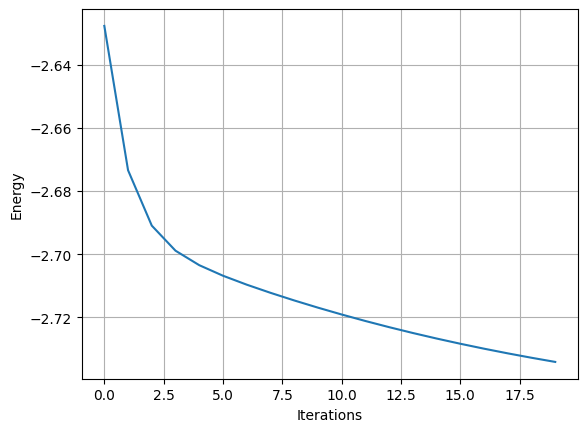

In [8]:
ev_n_up = env_ctm.measure_1site(n_up)
ev_n_dn = env_ctm.measure_1site(n_dn)
n_up_mean = mean_dict_values(ev_n_up)
n_dn_mean = mean_dict_values(ev_n_dn)
double_occ = env_ctm.measure_1site(n_up @ n_dn)
double_occ_mean = mean_dict_values(double_occ)

H_sparse_shifted = build_hamiltonian_shifted(L_x, L_y, (L_x * L_y) // 2, (L_x * L_y) // 2, t, U, use_pbc=False)
eigenvalues_shifted, _ = eigsh(H_sparse_shifted, k=1, which='SA')
ed_energy = eigenvalues_shifted[0] / (L_x * L_y)


print("----------------------------------------------------------------------------")
print(f"Ground State Energy per Site using fPEPS: {energy}") # type: ignore
print(f"Exact Ground State Energy per Site: {ed_energy}")
print(f"Error in Energy: {abs((energy - ed_energy) * 100 / ed_energy): .5f} %") # type: ignore
print("----------------------------------------------------------------------------")
print(f"<n_up>: {n_up_mean: .10f}")
print(f"<n_dn>: {n_dn_mean: .10f}")
print(f"Total Filling (<n_up + n_dn>): {n_up_mean + n_dn_mean: .10f}")
print(f"Double Occupancy (<n_up n_dn>): {double_occ_mean: .10f}")

plt.plot(list(range(len(energy_arr))), energy_arr)
plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.grid()
plt.show()

In [9]:
psi = env_ntu.psi

env_ctm = fpeps.EnvCTM(psi, init="eye")
opts_svd_ctm = {
    "D_total": chi,
    "tol": 1e-10,
}

ctm_iter = env_ctm.ctmrg_(
    opts_svd=opts_svd_ctm,
    iterator=True,
    max_sweeps=50,
)

energy_old = 0.0
tol_energy = 1e-7
sites_list = list(geometry.sites())
bonds_list = list(geometry.bonds())
num_sites = len(sites_list)
num_bonds = len(bonds_list)
z_eff = 2.0 * num_bonds / num_sites

# for info in ctm_iter:
on_site_op = (n_up - I / 2) @ (n_dn - I / 2)
ev_loc = env_ctm.measure_1site(on_site_op)
ev_loc_mean = mean_dict_values(ev_loc)

ev_cdagc_up = env_ctm.measure_nn(cdag_up, c_up)
ev_cdagc_dn = env_ctm.measure_nn(cdag_dn, c_dn)
ev_cdagc_up_mean = mean_dict_values(ev_cdagc_up)
ev_cdagc_dn_mean = mean_dict_values(ev_cdagc_dn)

E_kin_site = - z_eff * t * (ev_cdagc_up_mean + ev_cdagc_dn_mean)
E_loc_site = U * ev_loc_mean


energy = E_kin_site + E_loc_site

# if abs(energy - energy_old) < tol_energy:
#     break

energy_old = energy


ev_n_up = env_ctm.measure_1site(n_up)
ev_n_dn = env_ctm.measure_1site(n_dn)
n_up_mean = mean_dict_values(ev_n_up)
n_dn_mean = mean_dict_values(ev_n_dn)
double_occ = env_ctm.measure_1site(n_up @ n_dn)
double_occ_mean = mean_dict_values(double_occ)